# Example: Fake Stock Market

This notebook develops a fake stock market example. The resulting model incorporates a number of components of market behavior:
  - Correlation with previous prices;
  - Trends;
  - Shocks;
  - Price resistances.
  
By isolating each such component, the example demonstrates how one can model phenomena of interest by breaking it up in highly customized parts. Hence, contrary to traditional time series decompositions, which capture only a few standard components (e.g., trend, seasonality, noise), the present approach allows for the designer to use his or her full understanding of the domain under investigation to model it.

In the present example, some parameters will be fixed, while others will be randomly varied. Naturally, this model could be made either simpler or more complex, but for the sake of illustration we have taken some decisions to improve the clarity of the presentation. The reader might wish to modify the example for other uses, such as trying to fit the model to actual market data.

## Preliminaries

Import necessary libraries and define main parameters.

In [1]:
from time_blender.random_events import *
from time_blender.deterministic_events import *
from time_blender.coordination_events import *

from time_blender.core import *
from time_blender.models import SimpleModels, ClassicModels, BankingModels, EconomicModels, EcologyModels

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

Time period to consider.

In [3]:
start_date = pd.Timestamp.now()
end_date = start_date + pd.DateOffset(months=24)

print(f"Start date = {start_date}, end date = {end_date}")

Start date = 2020-10-29 20:11:20.907465, end date = 2022-10-29 20:11:20.907465


In termos of simulation steps, we have the following number.

In [4]:
n_steps = (end_date - start_date).days

How much the asset costs in the beginning?

In [5]:
initial_price = 100

## Model

The model is decomposed in several parts. For each part, a plot is also generated, in order to illustrate the nature of the component.

### Autoregressive behavior
We assume that future prices depend to some extent on previous prices. Let us assume a simple base autoregressive  model (AR).

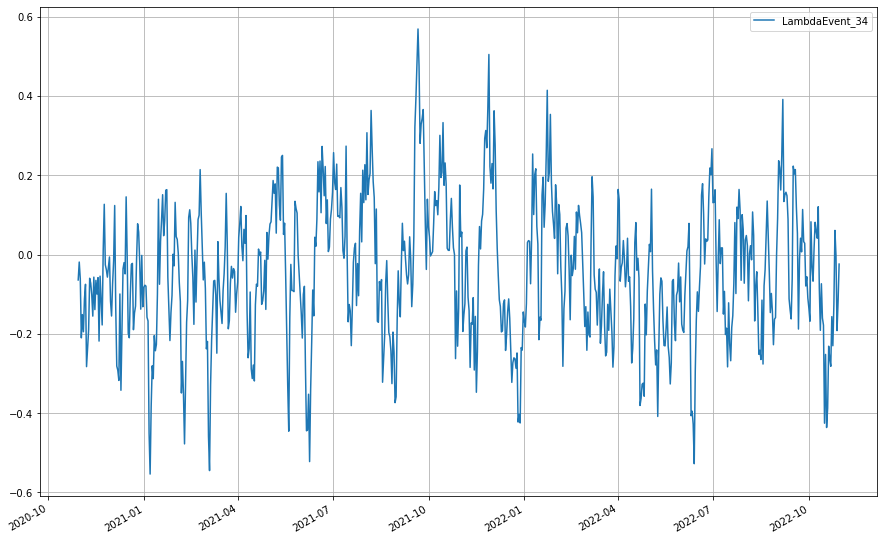

In [6]:
ar = ClassicModels.ar(5, constant=0, coefs=[0.7, 0.2, 0.1, -0.1, -0.1], error_std=0.05,
                      capture_parent_value=True) 

generate_and_plot(ar, start_date=start_date, end_date=end_date, n=1)

Note that the values are close to 0 in this plot. However, since the `capture_parent_value` is set to `True`, when this component is embedded in a larger model, the **autoregressive dynamics will actually use the final series' value as the past values** with which to build the new present values.

Despite these small numbers, note also that if we accumulate these changes, we get significant price changes over time.

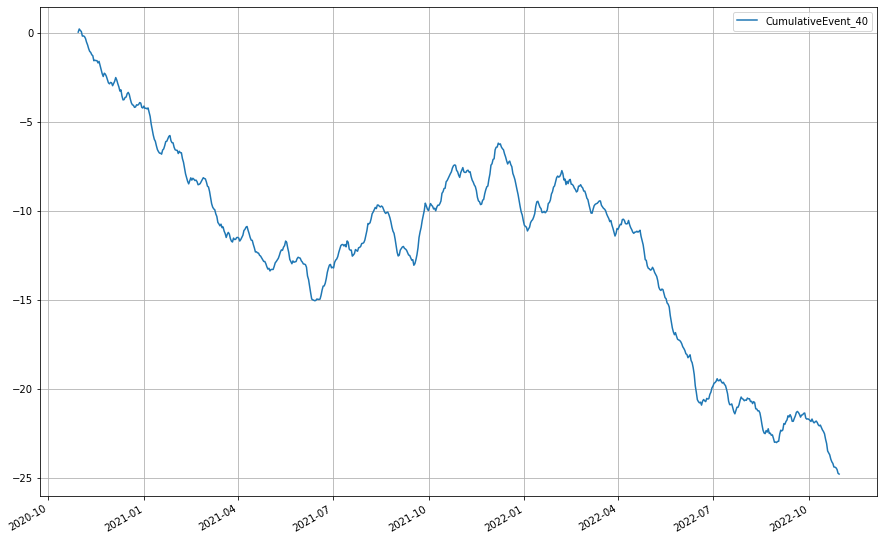

In [7]:
generate_and_plot(CumulativeEvent(ar), start_date=start_date, end_date=end_date, n=1)

### Trends

Although the AR component often induces values that resemble trends, we might wish to enforce the presence of such trends and, morever, have greater control over their behavior. For instance, let us define **three types of trends: upward, neutral and downard**.

In [8]:
trend_up = [ConstantEvent(i/10) for i in range(1, 3)]
trend_neutral = [ConstantEvent(0)]
trend_down = [ConstantEvent(i/10) for i in range(-3, -1)]

Note that the `Choice` operator allows the random selection of the trends to use.

In [9]:
trend =  WalkEvent(\
                   Choice(trend_up + trend_neutral + trend_down, fix_choice=True),
                   initial_pos=ConstantEvent(initial_price))

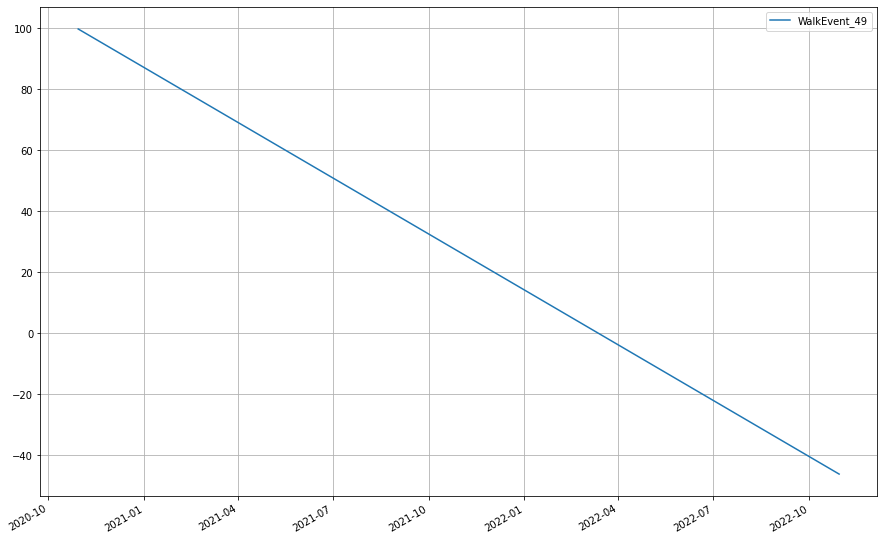

In [10]:
generate_and_plot(trend, start_date=start_date, end_date=end_date, n=1)

### Shocks

Sudden shocks are also part of typical market behavior. We'll define such sudden changes as a temporary switch to either a strong downard or upward movement. These changes could perhaps be modelled as trends as linear well, just as we did above. However, conceptually, they are different, and hence this difference is captured in the model. Moreover, this differentiation allow improvements to the understanding of one or the other to be more easily incorporated in newer versions of the model.

In [11]:
shock = TemporarySwitch(main_event=0,
                        alternative_event=Choice([NormalEvent(2, 1), 
                                                  NormalEvent(-2, 1),
                                                  NormalEvent(5, 2), 
                                                  NormalEvent(-5, 2),
                                                 ]),
                        switch_duration=ClipEvent(NormalEvent(20, 5), 
                                                 min_value=0.0),
                       switch_probability=0.001)  

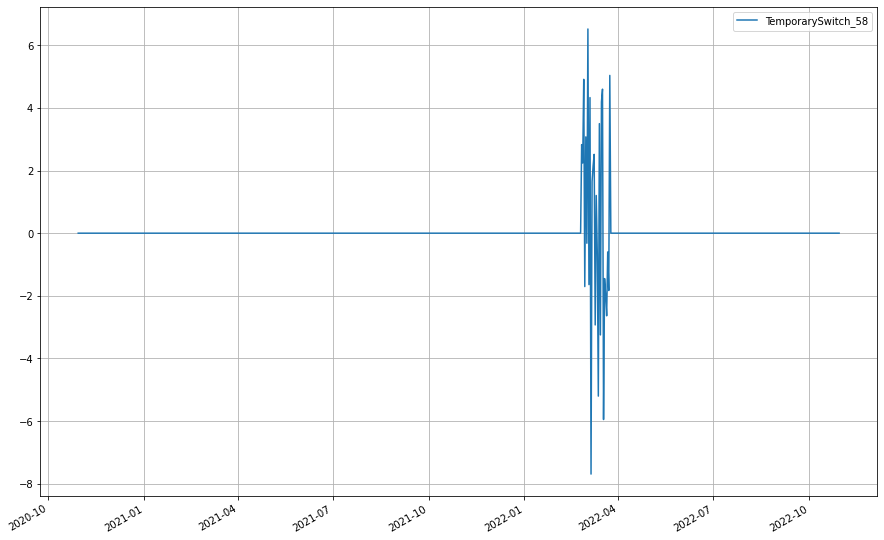

In [12]:
generate_and_plot(shock, start_date=start_date, end_date=end_date, n=1)

### Resistances

Markets are known to display tops and bottoms, which offer resistance to further price movement in a direction. 

In [13]:
top_resistance_levels = [120, 150]
bottom_resistance_levels = [70, 50]

Later we will use the standard function `wrap_in_resistance()` to apply these levels.

### Noise

Finally, some additional noise can be added.

In [14]:
noise_1 = NormalEvent(0, 0.005)
noise_2 = NormalEvent(0, 0.01)
noise_3 = NormalEvent(0, 0.02)

In [15]:
noise = (ConstantEvent(1) + Choice([noise_1, noise_2, noise_3], fix_choice=True))

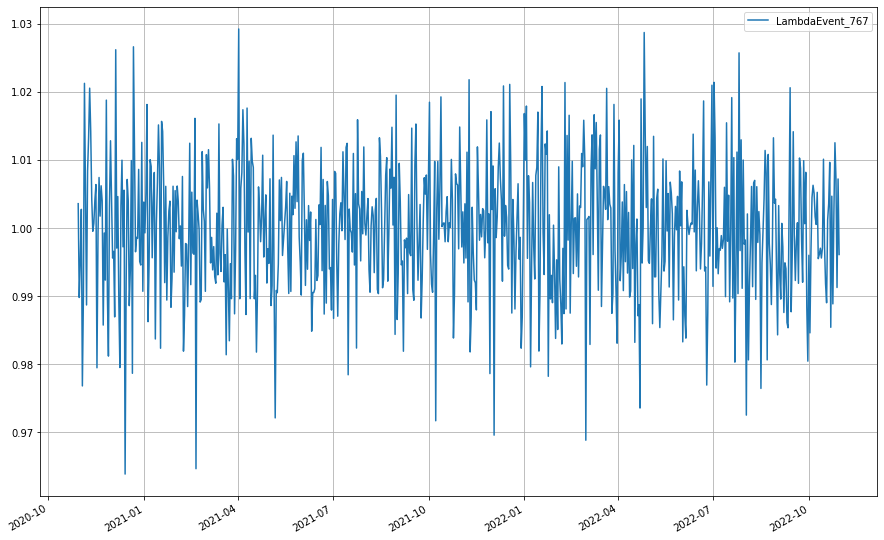

In [16]:
generate_and_plot(noise, start_date=start_date, end_date=end_date, n=1)

The noise is to be used in a multiplicative manner, hence he minute standard deviations.

### Combine Everything

To combine everything, first we define some segments of the time series, which correspond to separate "market regimes".

Each segment is a sum of its main components multiplied by the noise. The noise is a multiplicative instead of an additive component in order to be proportional to the current value.

In [17]:
model_segment = (ar + trend + shock) * noise

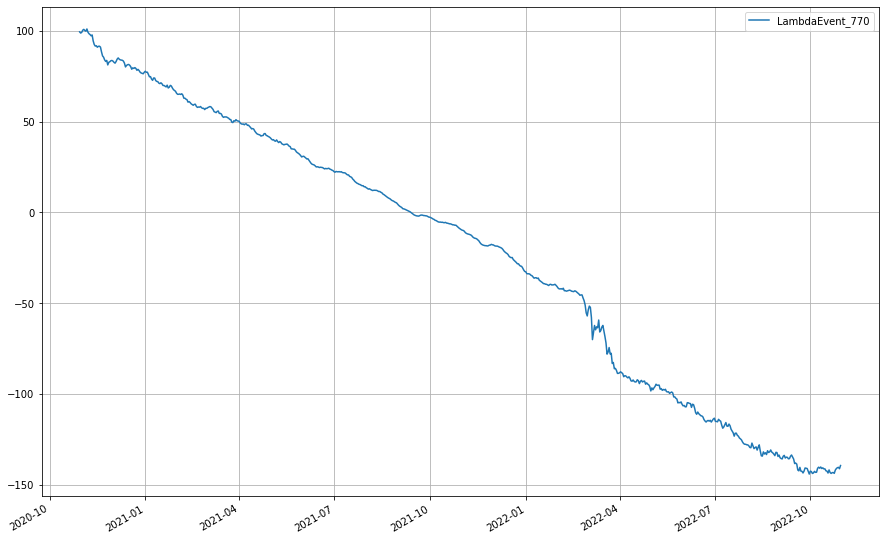

In [18]:
generate_and_plot(model_segment, start_date=start_date, end_date=end_date, n=1)

For this example, we will assume at most 5 different "regime changes", with corresponding (random) points in time.

In [19]:
segments = 5

In [20]:
t_change = OnceEvent(UniformEvent(0, n_steps))

Finally, we can put the several segments together to build the final model. It is also necessary to wrap everything in:
  - a `SeasonalEvent`, which defined that trading only happens in weekdays;
  - resistances, using the function previously defined;
  - a `ClipEvent`, in order to ensure that prices never go below zero.

In [21]:
model =  ClipEvent(wrap_in_resistance(SeasonalEvent(\

                                        Piecewise(events=[model_segment.clone() for i in range(0, segments)],

                                                  t_separators=[t_change.clone() for i in range(0, segments-1)]),
                                    
                                    is_weekday=True),
                            
                            top_resistance_levels=top_resistance_levels,
                            bottom_resistance_levels=bottom_resistance_levels,
                            top_resistance_strength_event=ClipEvent(NormalEvent(0.02, 0.01), min_value=0.0),
                            bottom_resistance_strength_event=ClipEvent(NormalEvent(0.02, 0.01), min_value=0.0),
                            top_resistance_probability=0.5, 
                            bottom_resistance_probability=0.5),
                  
                   name='Fake Market',
                   min_value=0.0)


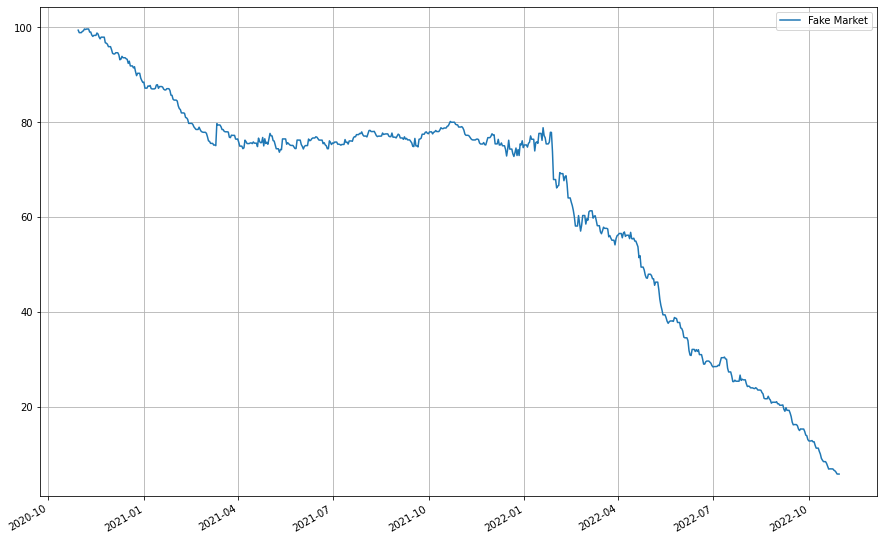

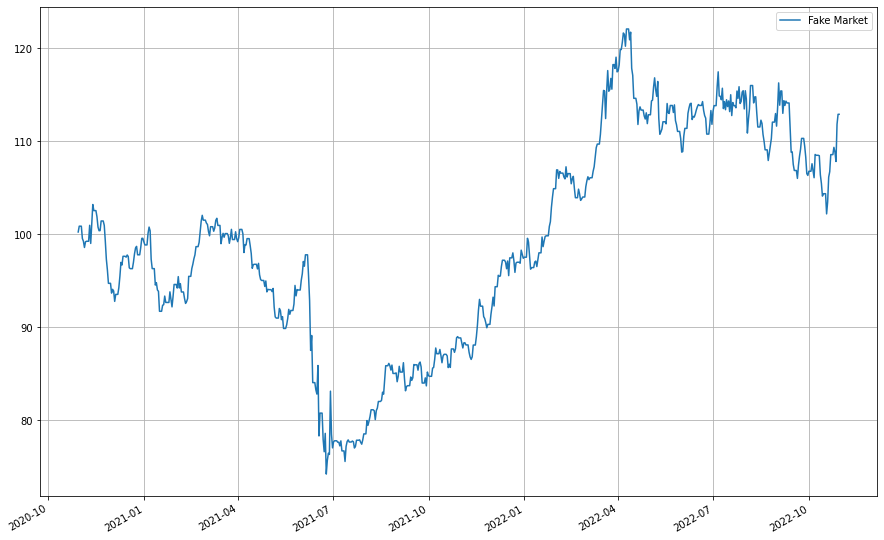

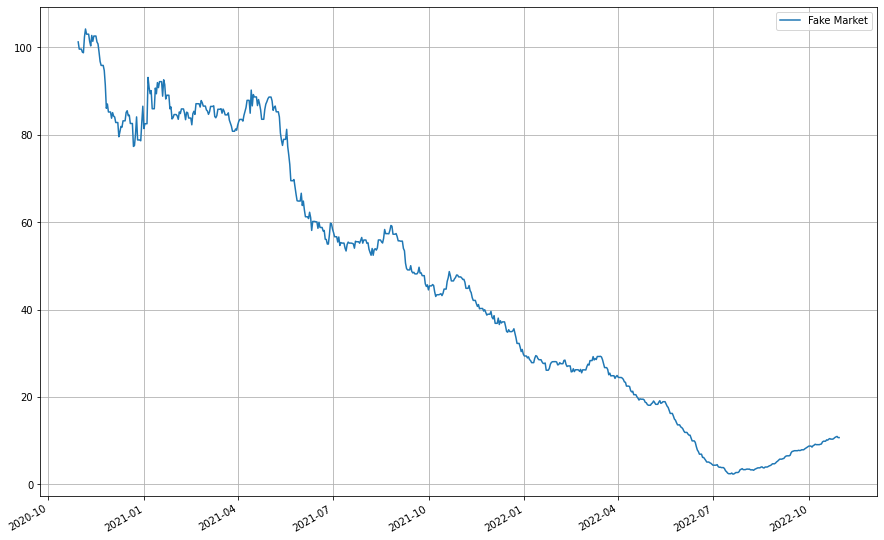

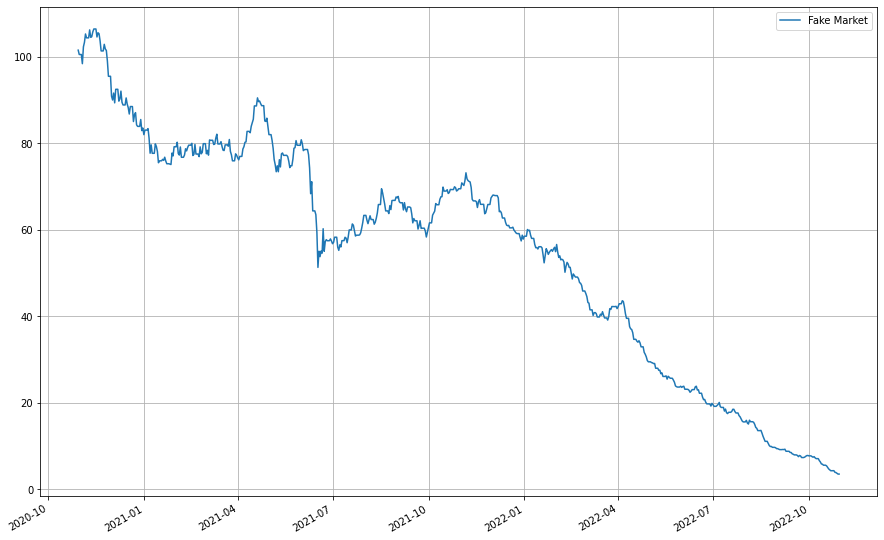

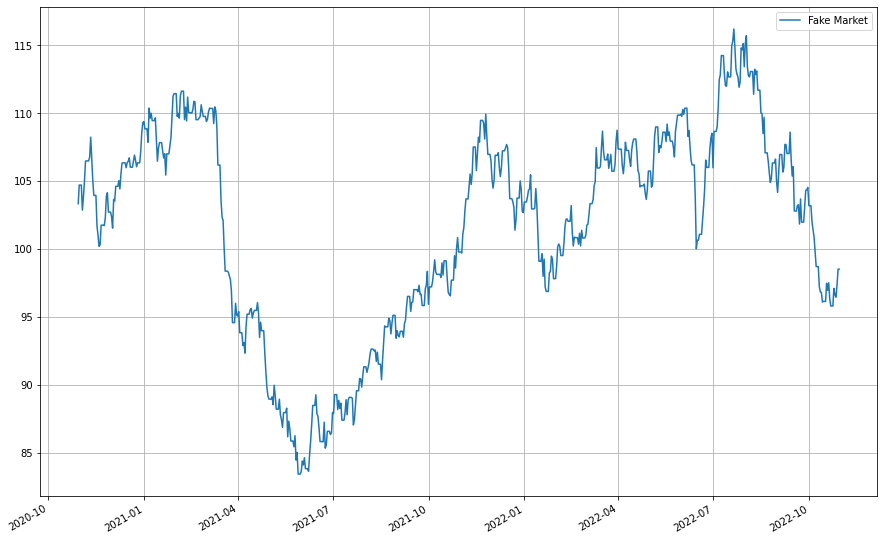

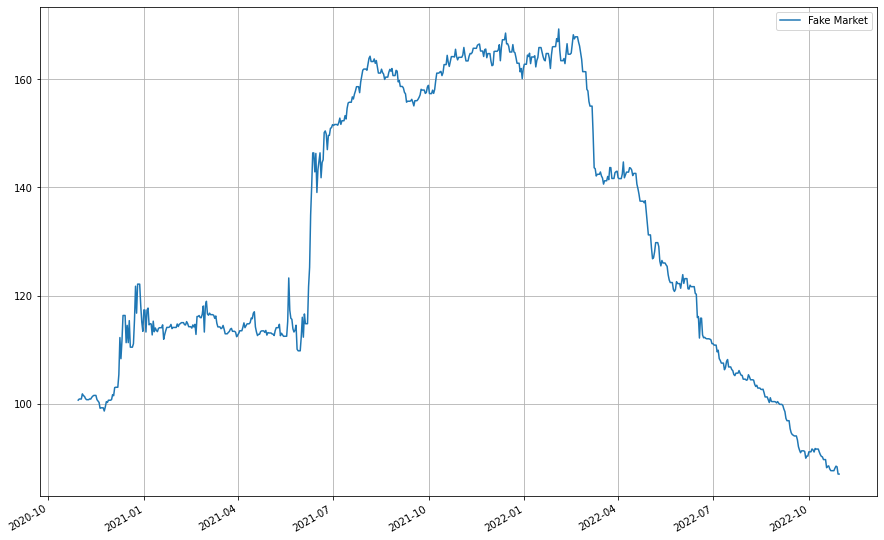

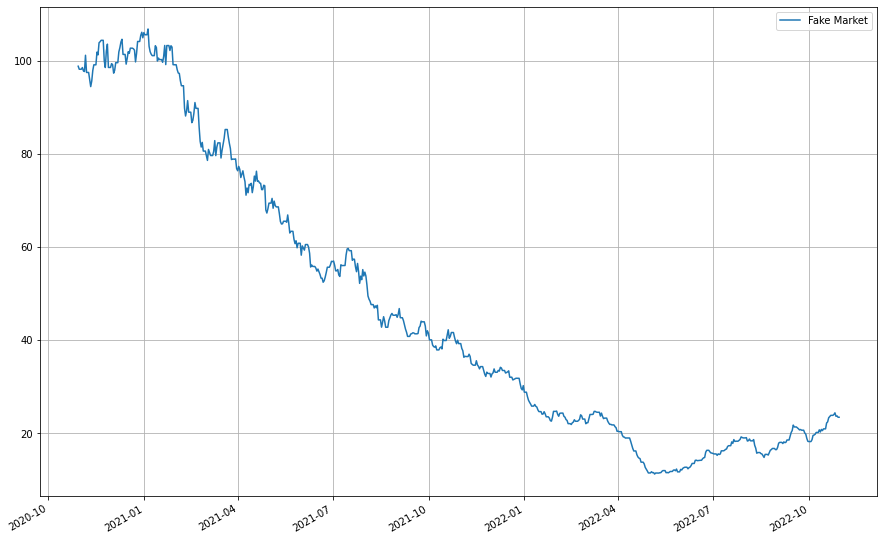

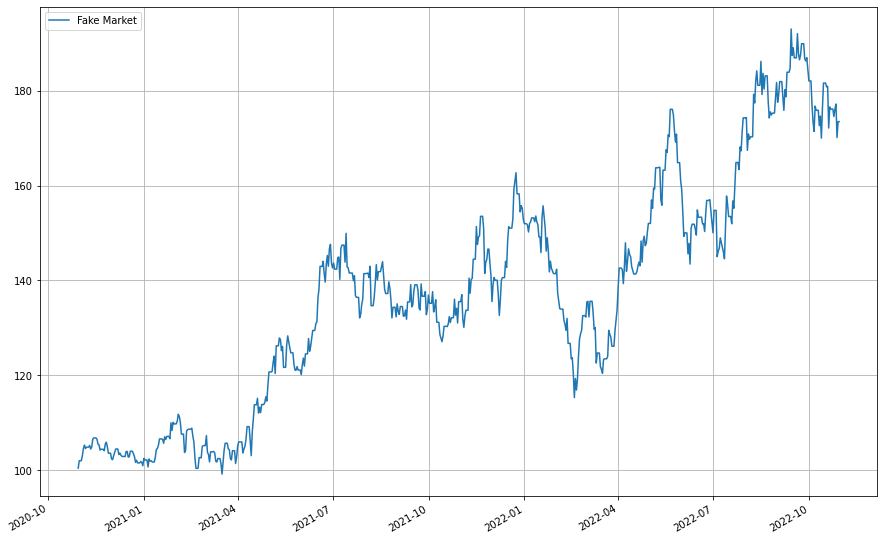

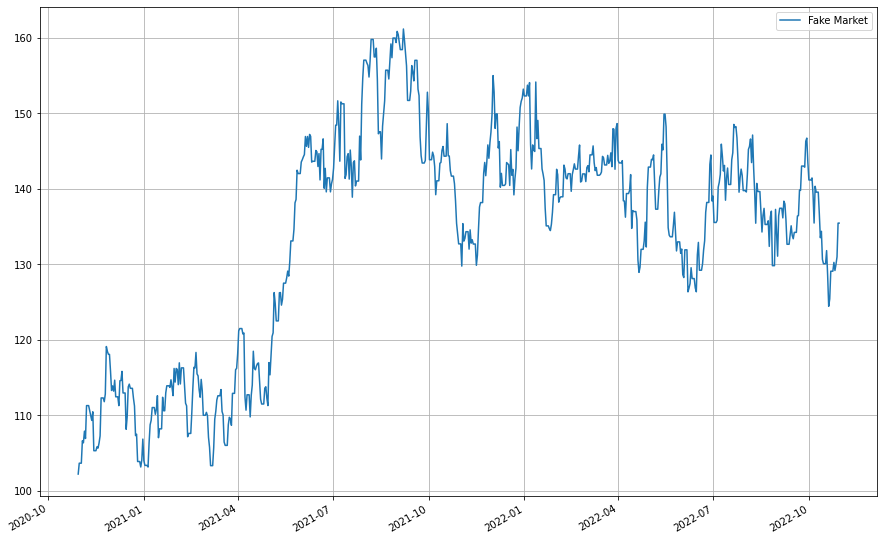

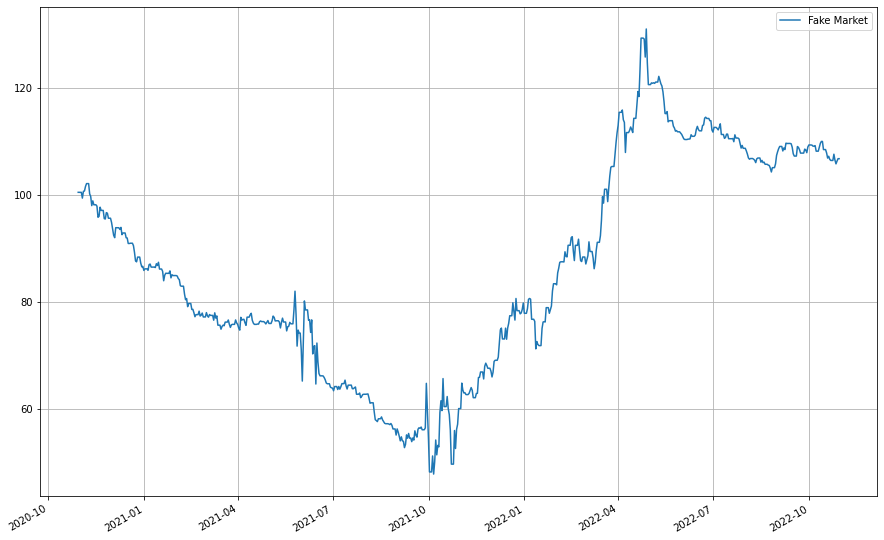

In [22]:
data = generate_and_plot(model, start_date=start_date, end_date=end_date, n=10, return_data=True)

Since the data is given as a Pandas DataFrame, the values can be inspected and saved to files if desired.

In [23]:
data[0].iloc[:20]

,Fake Market
2020-10-29 20:11:20.907465,99.401948
2020-10-30 20:11:20.907465,98.880635
2020-10-31 20:11:20.907465,98.880635
2020-11-01 20:11:20.907465,98.880635
2020-11-02 20:11:20.907465,99.151134
2020-11-03 20:11:20.907465,99.264007
2020-11-04 20:11:20.907465,99.653164
2020-11-05 20:11:20.907465,99.547357
2020-11-06 20:11:20.907465,99.646052
2020-11-07 20:11:20.907465,99.646052


In [24]:
data[0].to_csv('fake_stock_market.csv')